# Librerias

In [131]:
# Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import date

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from prophet import Prophet
from colorama import Fore

#Const

URL = ("../data/raw/Aquifer_Petrignano.csv")

# Carga de datos

In [2]:
def GetData(url):

    data = pd.read_csv(url)

    print(f"Original Data Shape:{data.shape}\n==========\n")
    #Vamos a aprovechar para hacer una primera limpieza de los datos eliminando datos vacios de fechas antiguas.
    eraseData = data[data.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
    
    #Tambien eliminamos las columnas irrelevantes.
    eraseData.drop(["Depth_to_Groundwater_P24","Temperature_Petrignano"], axis=1, inplace=True)

    #Convertimos Date en un formato valido

    eraseData["Date"] = pd.to_datetime(eraseData["Date"], format = "%d/%m/%Y")
    
    print(f"Erased Data Shape: {eraseData.shape}")
    return eraseData

data = GetData(URL)

data

Original Data Shape:(5223, 8)

Erased Data Shape: (4199, 6)


,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3
...,...,...,...,...,...,...
4194,2020-06-26,0.0,-25.07,25.7,-29930.688,2.5
4195,2020-06-27,0.0,-25.11,26.2,-31332.960,2.4
4196,2020-06-28,0.0,-25.19,26.9,-32120.928,2.4
4197,2020-06-29,0.0,-25.18,26.9,-30602.880,2.4


### ¿Porque eliminamos esas dos columnas?
-------

* Depth_To_Groundwater_p24: P24 es la planta de la ciudad de Petrignano pero se va a utilizar el p25, la de Bastia Umbra.
* Temperature_Petrignano: Lo mismo, utilizamos la temperatura de Bastia Umbra.

# Analisis de Datos

/tmp/ipykernel_3231/264734904.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=dataset["Date"], y=dataset[column].fillna(method='ffill'), ax=axis[i])
/tmp/ipykernel_3231/264734904.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=dataset["Date"], y=dataset[column].fillna(method='ffill'), ax=axis[i])
/tmp/ipykernel_3231/264734904.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=dataset["Date"], y=dataset[column].fillna(method='ffill'), ax=axis[i])
/tmp/ipykernel_3231/264734904.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=dataset["Date"], y=dataset[column].fillna(m

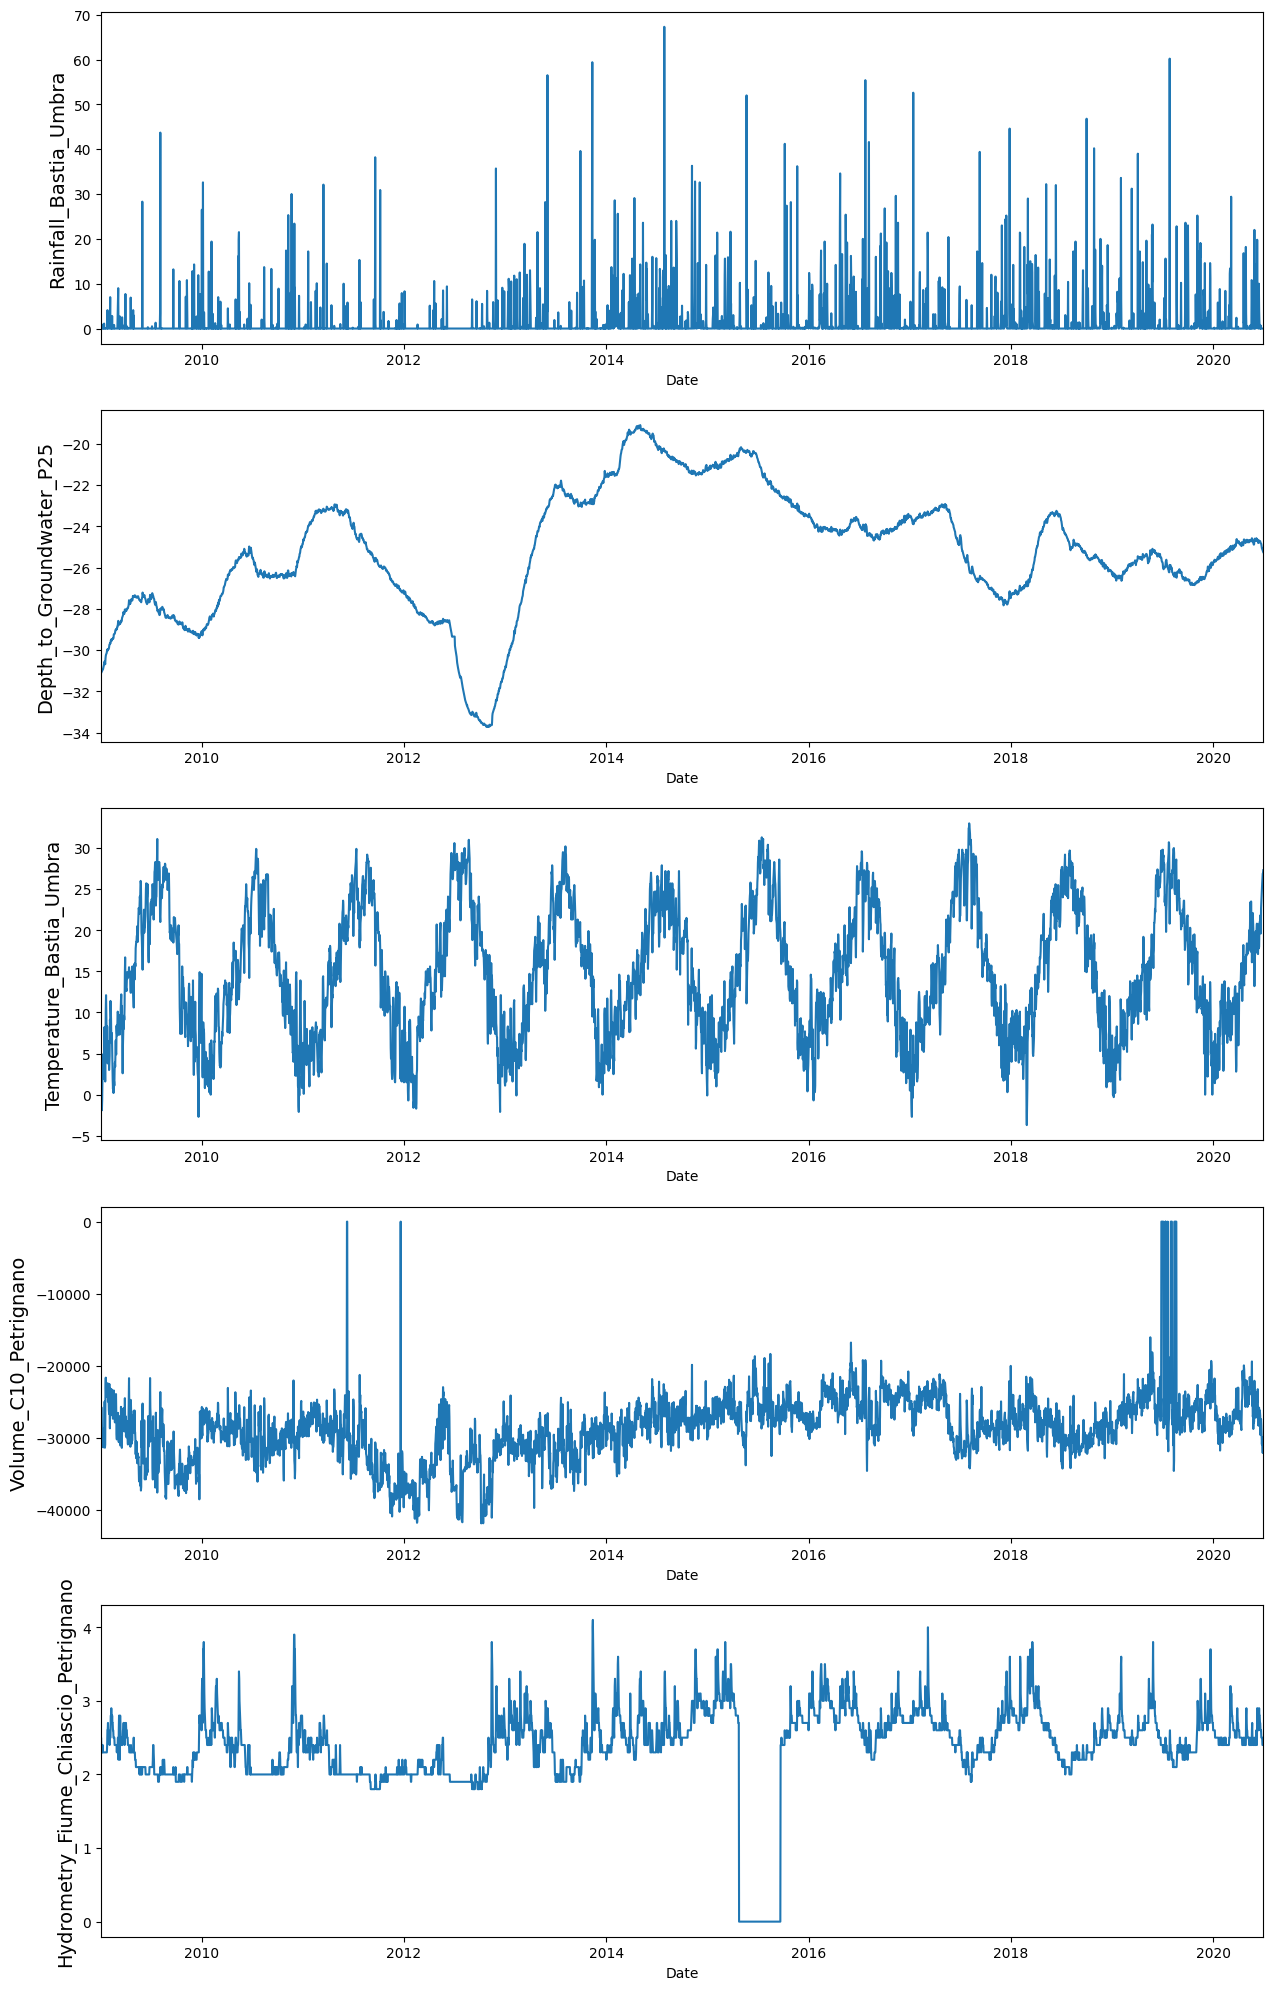

In [3]:
def GraphData (dataset):
    fig, axis = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

    for i, column in enumerate(dataset.drop("Date", axis=1).columns):
        sns.lineplot(x=dataset["Date"], y=dataset[column].fillna(method='ffill'), ax=axis[i])
        axis[i].set_ylabel(ylabel=column, fontsize=14)
                      
        axis[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

GraphData(data) 

# Procesamiento de los datos

In [4]:
def DateFormat(dataset):

    #Primero comprobamos que todas las celdas tengan una periodizidad de tiempo entre ellas.
    dataset = dataset.sort_values(by = "Date")
    dataset["delta"] = dataset["Date"] - dataset["Date"].shift(1)

    print("Transform date format...\n")
    
    for i, value in enumerate(dataset["delta"].iloc[1:], start=1):
        
        if pd.isna(value):
            return f"Error de NaN en la fila {i + 1}"
        
        elif value != pd.Timedelta(days=1):
            return f"Error de intervalo diferente a 1 día en la fila {i + 1}, intervalo: {value}"

    #Eliminamos delta, ya no hace falta.

    dataset.drop(["delta"], axis = 1, inplace = True)

    return dataset

dateFormat_data = DateFormat(data)

Transform date format...



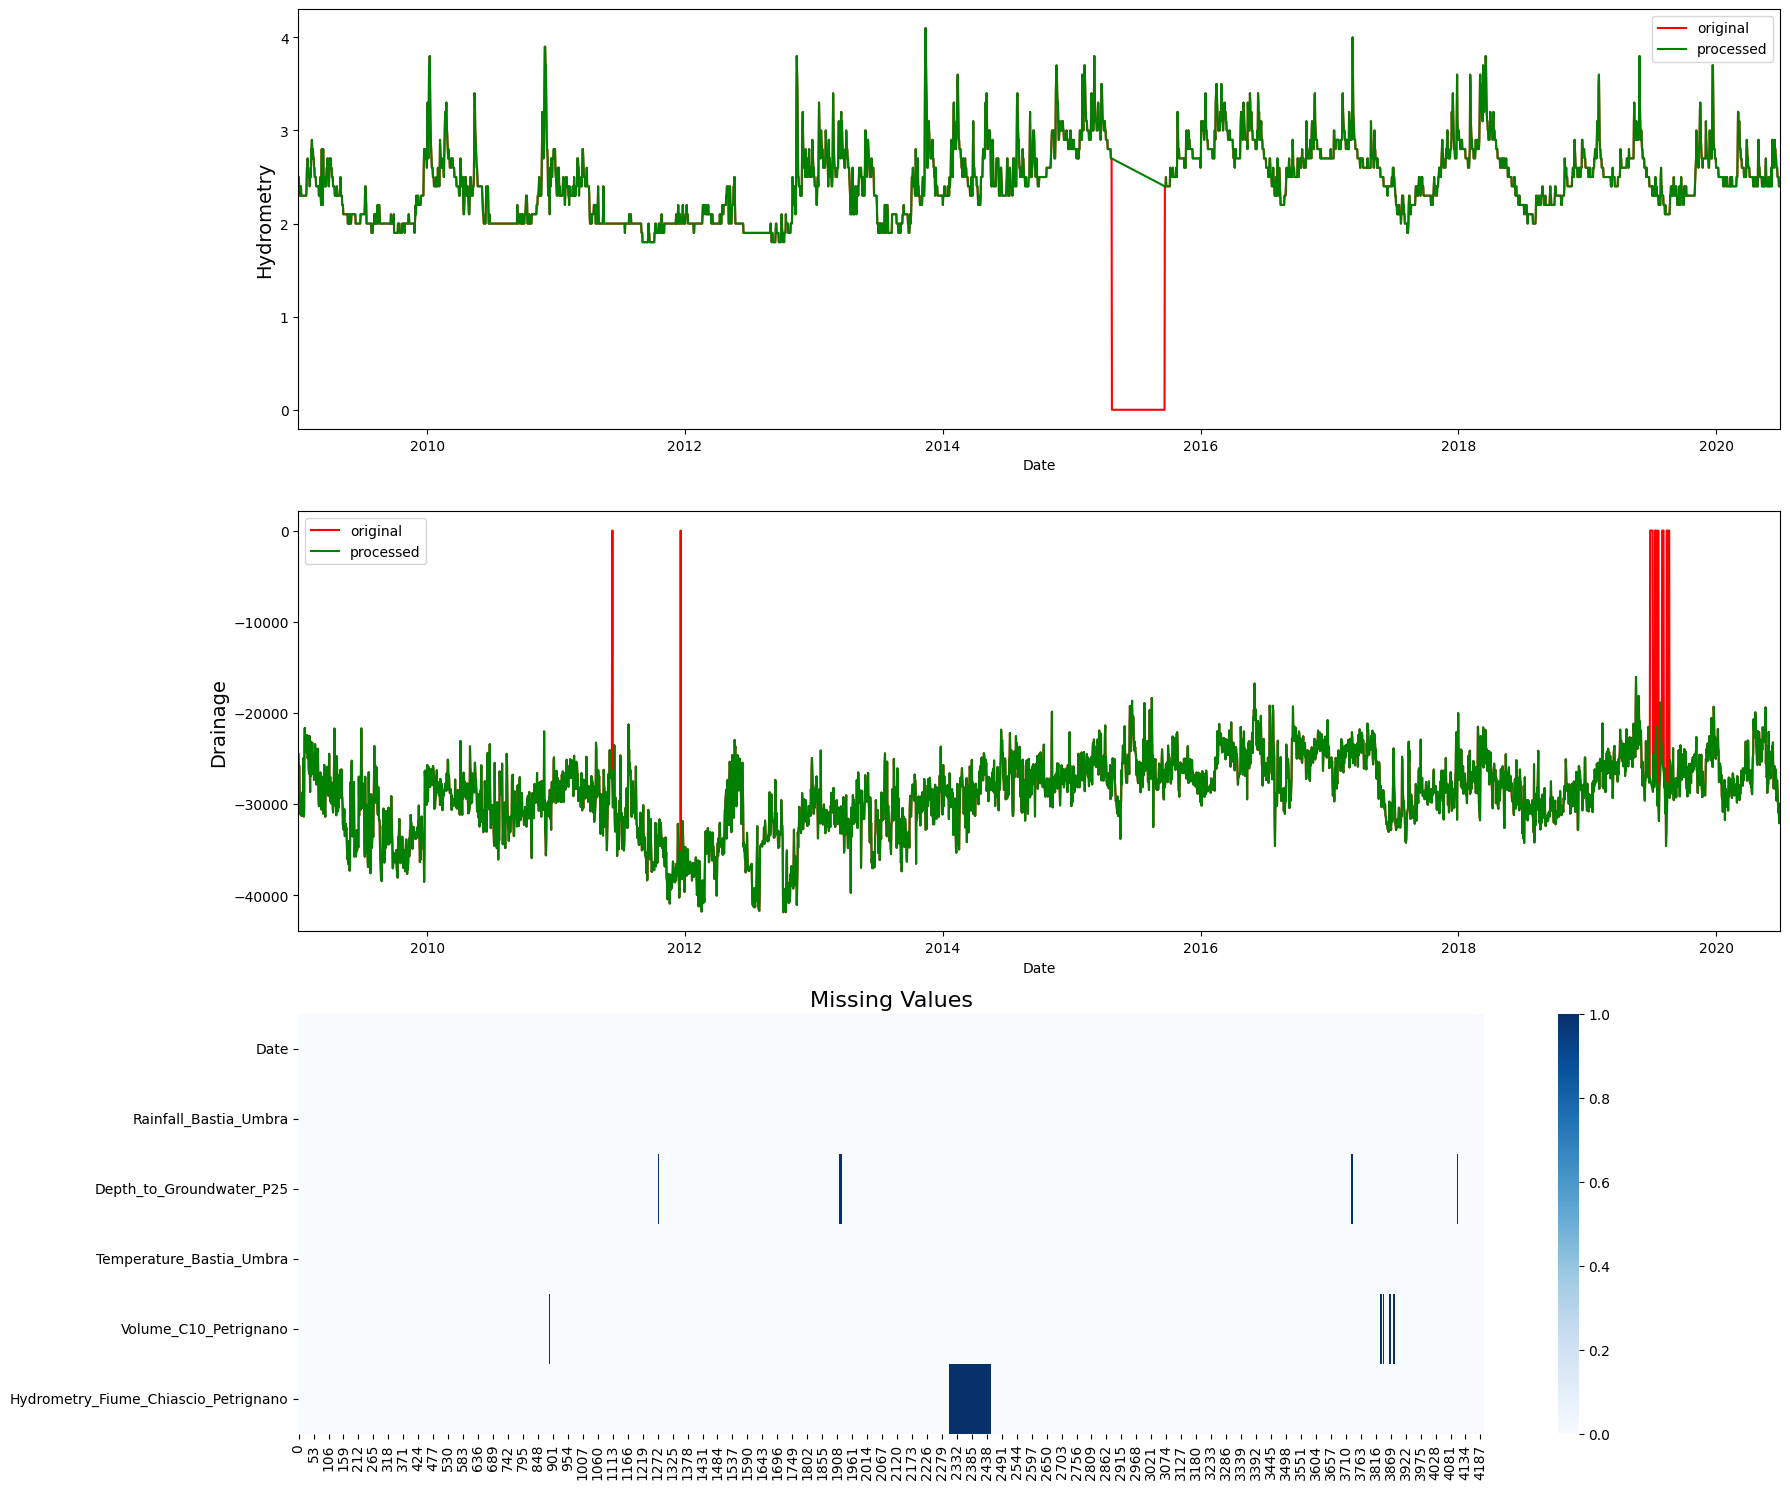

In [5]:
#Vamos a graficarlo para comparar los valores irreales con los que tenemos ahora mismo.

def GraphComparate(dataset):
    fig, axis = plt.subplots(3, 1, figsize=(18, 15))

    #Grafica Hidrometria original vs procesada con NaNs.

    old_hydrometry = dataset["Hydrometry_Fiume_Chiascio_Petrignano"].copy()
    dataset["Hydrometry_Fiume_Chiascio_Petrignano"] = dataset["Hydrometry_Fiume_Chiascio_Petrignano"].replace(0, np.nan)

    sns.lineplot(x=dataset["Date"], y=old_hydrometry, ax=axis[0], color='red', label='original')
    sns.lineplot(x=dataset["Date"], y=dataset["Hydrometry_Fiume_Chiascio_Petrignano"].fillna(np.inf), ax=axis[0], color='green', label='processed')
    axis[0].set_ylabel(ylabel='Hydrometry', fontsize=14)

    axis[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

    #Grafica Volumen original vs procesada con NaNs.

    old_drainage = dataset["Volume_C10_Petrignano"].copy()
    dataset["Volume_C10_Petrignano"] = dataset["Volume_C10_Petrignano"].replace(0, np.nan)

    sns.lineplot(x=dataset["Date"], y=old_drainage, ax=axis[1], color='red', label='original')
    sns.lineplot(x=dataset["Date"], y=dataset["Volume_C10_Petrignano"].fillna(np.inf), ax=axis[1], color='green', label='processed')
   
    axis[1].set_ylabel(ylabel='Drainage', fontsize=14)
    axis[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

    #Grafica mostrando los NaN


    sns.heatmap(dataset.T.isna(), cmap='Blues')
    axis[2].set_title('Missing Values', fontsize=16)
    
    plt.tight_layout()

    plt.show()

GraphComparate(dateFormat_data)

- Vemos que tenemos valores nulos en la profundidad del aquifero (Que es el target), en el volumen y en la hidrometria

- Procesamiento de nulos (Metodo Interpolate)

In [6]:
def InterpolateData(dataset):

    #Primero quiero verificar que columnas tienen NaN y guardarlas en una lista.
    
    col_name = []

    #Una vez creada la lista con NaNs vamos a pasarla por la interpolacion.

    print("NaN values:\n")
    for i in dataset.columns:
        if dataset[i].isna().any():
            print(f"{i}: {dataset[i].isna().sum()}")
            col_name.append(dataset[i].name)
    print("==========\n")

    print("Interpolating NaN values:\n")
    for col in col_name:
        dataset[col] = dataset[col].interpolate()
        print(f"Succesfull interpolated {col} column...")
    print("==========\n")

    return dataset


processed_Data = InterpolateData(dateFormat_data)

NaN values:

Depth_to_Groundwater_P25: 27
Volume_C10_Petrignano: 26
Hydrometry_Fiume_Chiascio_Petrignano: 150

Interpolating NaN values:

Succesfull interpolated Depth_to_Groundwater_P25 column...
Succesfull interpolated Volume_C10_Petrignano column...
Succesfull interpolated Hydrometry_Fiume_Chiascio_Petrignano column...



In [8]:
processed_Data.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,2009-01-01,0.0,-31.14,5.2,-24530.688,2.4
1,2009-01-02,0.0,-31.11,2.3,-28785.888,2.5
2,2009-01-03,0.0,-31.07,4.4,-25766.208,2.4
3,2009-01-04,0.0,-31.05,0.8,-27919.296,2.4
4,2009-01-05,0.0,-31.01,-1.9,-29854.656,2.3


# Remuestreo de los Datos

- Antes de aplicar un resample definitivo vamos a mostrarlo de forma visual, tanto decreciente como creciente, para decidirnos por uno.

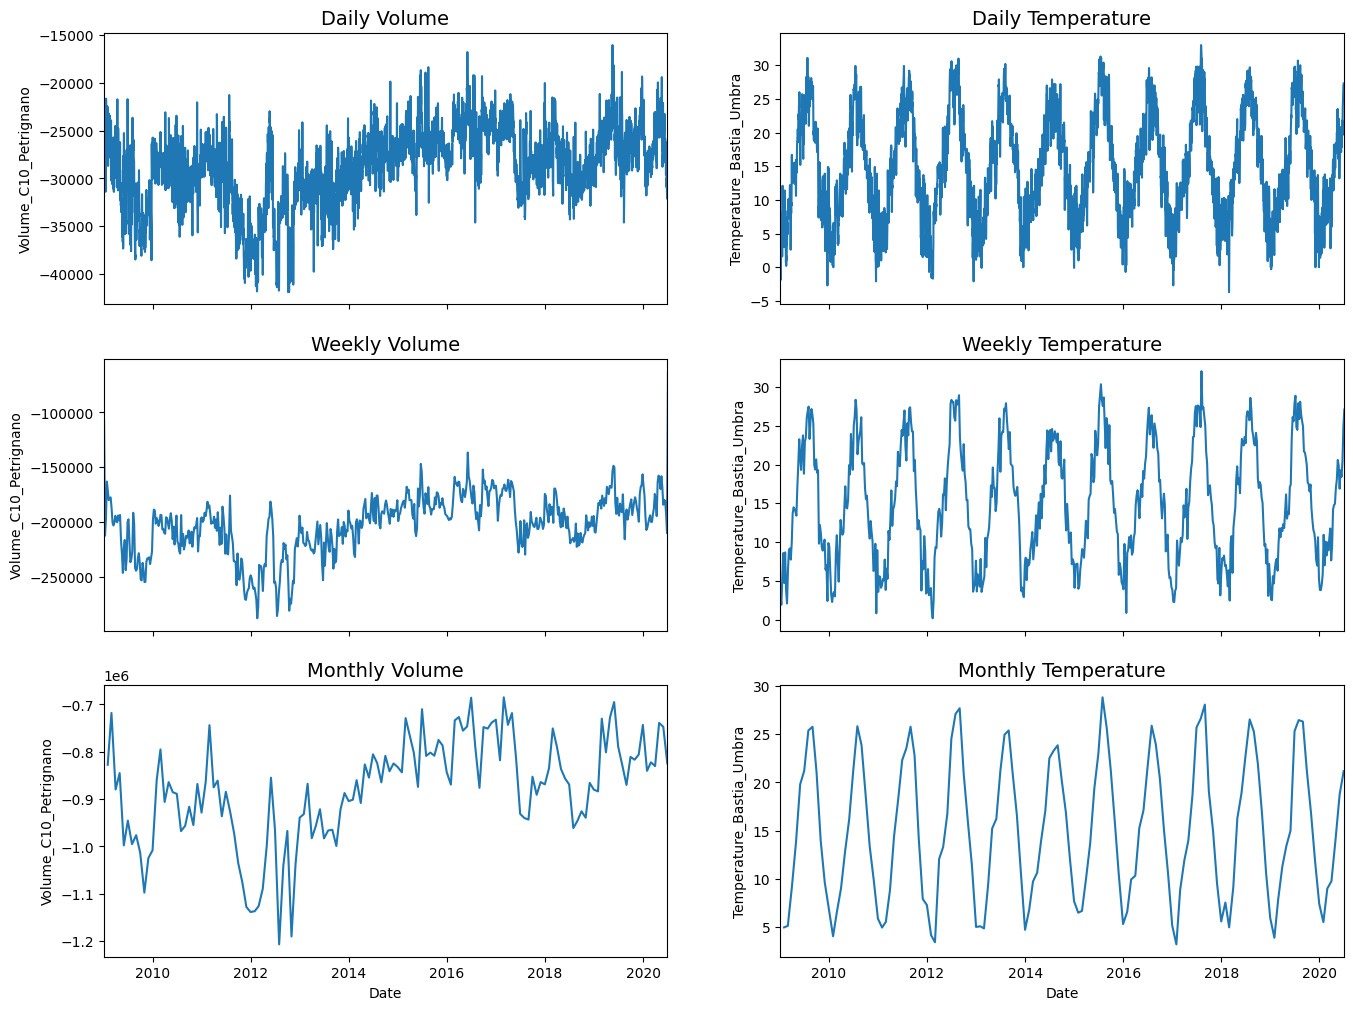

In [14]:
def GraphResample(dataset):

    fig, axis = plt.subplots(3, 2, sharex=True, figsize=(16,12))

    sns.lineplot(x=dataset["Date"], y=dataset["Volume_C10_Petrignano"], ax=axis[0, 0])
    axis[0, 0].set_title("Daily Volume", fontsize=14)

    resampled_df = dataset[["Date","Volume_C10_Petrignano"]].resample('W', on="Date").sum().reset_index(drop=False)
    sns.lineplot(x=resampled_df["Date"], y=resampled_df["Volume_C10_Petrignano"], ax=axis[1, 0])
    axis[1, 0].set_title('Weekly Volume', fontsize=14)

    resampled_df = dataset[["Date","Volume_C10_Petrignano"]].resample('ME', on="Date").sum().reset_index(drop=False)
    sns.lineplot(x=resampled_df["Date"], y=resampled_df["Volume_C10_Petrignano"], ax=axis[2, 0])
    axis[2, 0].set_title('Monthly Volume', fontsize=14)

    for i in range(3):
        axis[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

    sns.lineplot(x=dataset["Date"], y=dataset["Temperature_Bastia_Umbra"], ax=axis[0, 1])
    axis[0, 1].set_title('Daily Temperature', fontsize=14)

    resampled_df = dataset[["Date","Temperature_Bastia_Umbra"]].resample('W', on="Date").mean().reset_index(drop=False)
    sns.lineplot(x=resampled_df["Date"], y=resampled_df["Temperature_Bastia_Umbra"], ax=axis[1, 1])
    axis[1, 1].set_title('Weekly Temperature', fontsize=14)

    resampled_df = dataset[["Date", "Temperature_Bastia_Umbra"]].resample('ME', on="Date").mean().reset_index(drop=False)
    sns.lineplot(x=resampled_df["Date"], y=resampled_df["Temperature_Bastia_Umbra"], ax=axis[2, 1])
    axis[2, 1].set_title('Monthly Temperature', fontsize=14)

    for i in range(3):
        axis[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    plt.show()

GraphResample(processed_Data)

- Podemos apreciar que el resample semanal limpia mucho del ruido que se generaba en la grafica original.

- En cambio el resample mensual simplifica demasiado los datos.

In [15]:
def Resample(dataset):
    
    data_resample = dataset[["Date", "Rainfall_Bastia_Umbra", "Depth_to_Groundwater_P25", "Temperature_Bastia_Umbra", "Volume_C10_Petrignano", "Hydrometry_Fiume_Chiascio_Petrignano"]].resample("W", on="Date").mean().reset_index()

    return data_resample

weeklyData = Resample (processed_Data)

weeklyData

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,2009-01-04,0.000000,-31.092500,3.175000,-26750.520000,2.425000
1,2009-01-11,0.128571,-30.934286,1.914286,-30309.243429,2.314286
2,2009-01-18,0.171429,-30.598571,5.485714,-28089.257143,2.300000
3,2009-01-25,0.600000,-30.130000,8.585714,-23269.124571,2.357143
4,2009-02-01,0.000000,-29.907143,4.728571,-24487.117714,2.571429
...,...,...,...,...,...,...
596,2020-06-07,2.800000,-24.652857,19.271429,-25637.965714,2.442857
597,2020-06-14,6.142857,-24.724286,18.428571,-25804.841143,2.771429
598,2020-06-21,1.057143,-24.752857,20.385714,-27476.496000,2.728571
599,2020-06-28,0.000000,-25.017143,24.928571,-29972.900571,2.485714


# Comprobar Estacionalidad

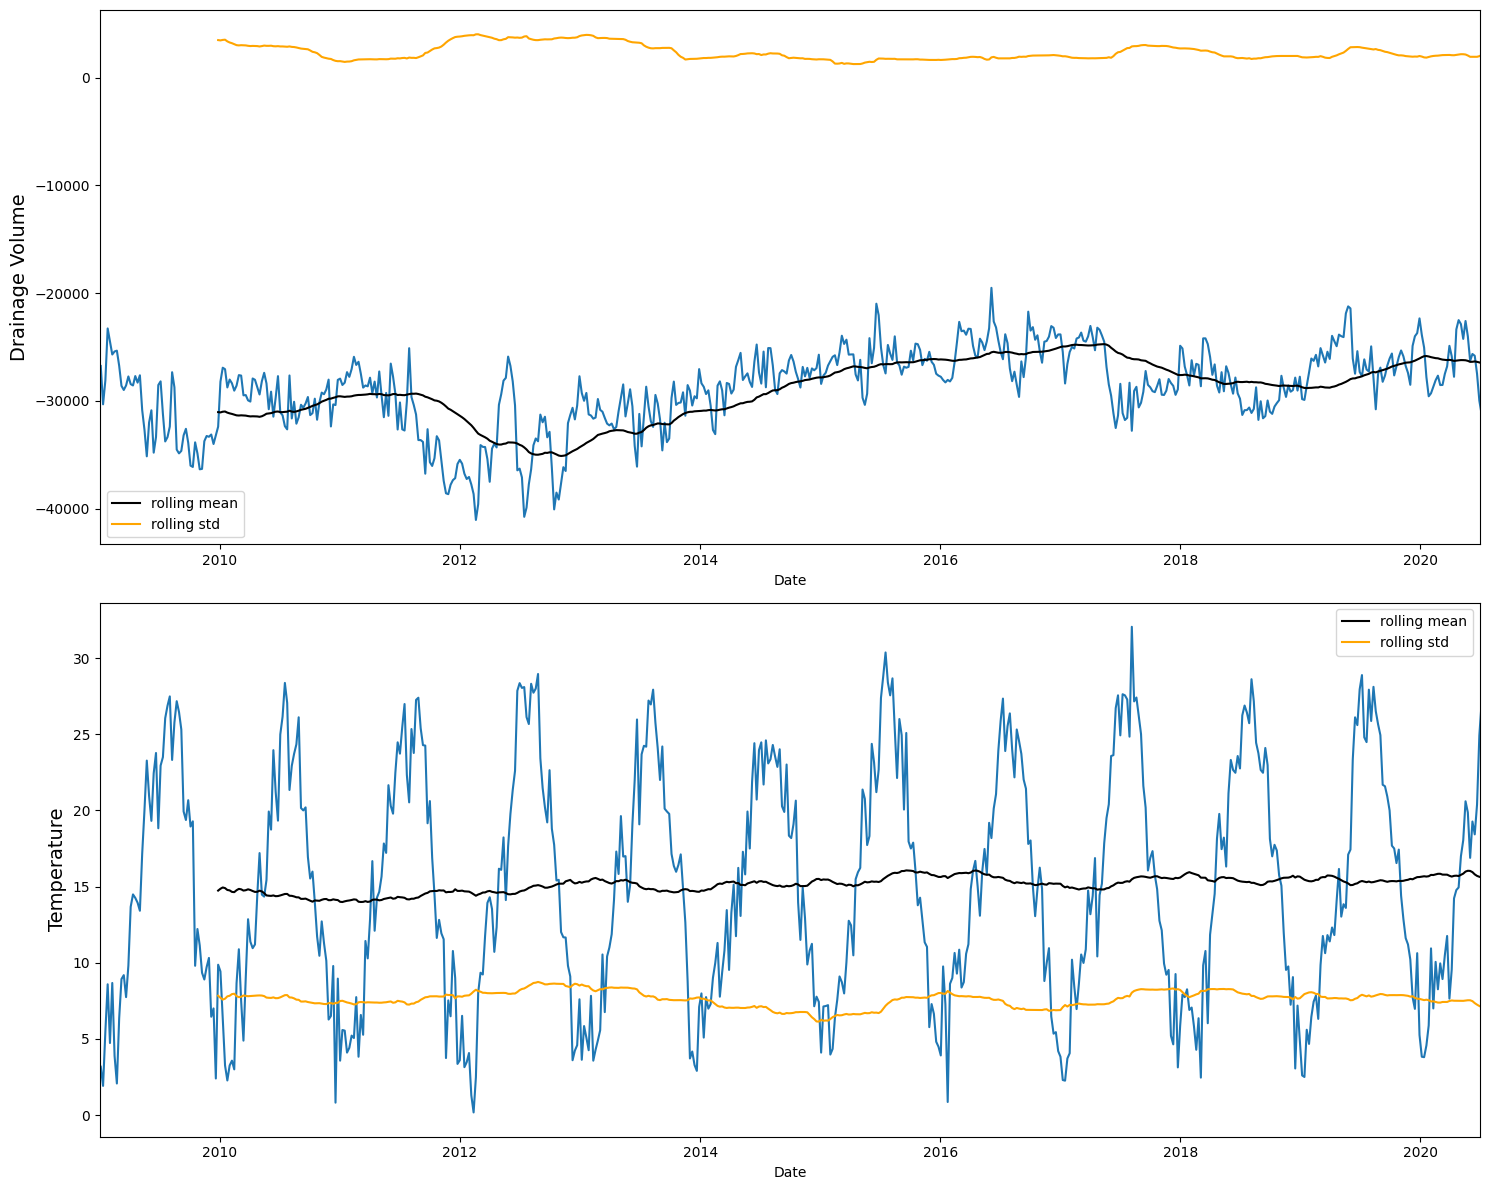

In [20]:
def GraphStationarity(dataset):

    fig, axis = plt.subplots(2, 1, figsize=(15, 12))

    sns.lineplot(x=dataset["Date"], y=dataset["Volume_C10_Petrignano"], ax=axis[0])
    sns.lineplot(x=dataset["Date"], y=dataset["Volume_C10_Petrignano"].rolling(window = 52).mean(), ax=axis[0], color='black', label='rolling mean')
    sns.lineplot(x=dataset["Date"], y=dataset["Volume_C10_Petrignano"].rolling(window = 52).std(), ax=axis[0], color='orange', label='rolling std')
   
    axis[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
    axis[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

    sns.lineplot(x=dataset["Date"], y=dataset["Temperature_Bastia_Umbra"], ax=axis[1])
    sns.lineplot(x=dataset["Date"], y=dataset["Temperature_Bastia_Umbra"].rolling(window = 52).mean(), ax=axis[1], color='black', label='rolling mean')
    sns.lineplot(x=dataset["Date"], y=dataset["Temperature_Bastia_Umbra"].rolling(window = 52).std(), ax=axis[1], color='orange', label='rolling std')
    
    axis[1].set_ylabel(ylabel='Temperature', fontsize=14)
    axis[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

    plt.tight_layout()
    plt.show()

GraphStationarity(weeklyData)

- En el volumen no vemos estacionalidad, además la media y la desviacion estandar están muy alejadas. Esto significa que hay mucha incertidumble.

- En cuanto a la temperatura a simple vista si se ve estacionalidad. Además la media y la desviacion estandar están más cercas entre si, lo cual deja ver que no hay una gran variación entre un ciclo y otro.

# Augmented Dickey-Fuller Test

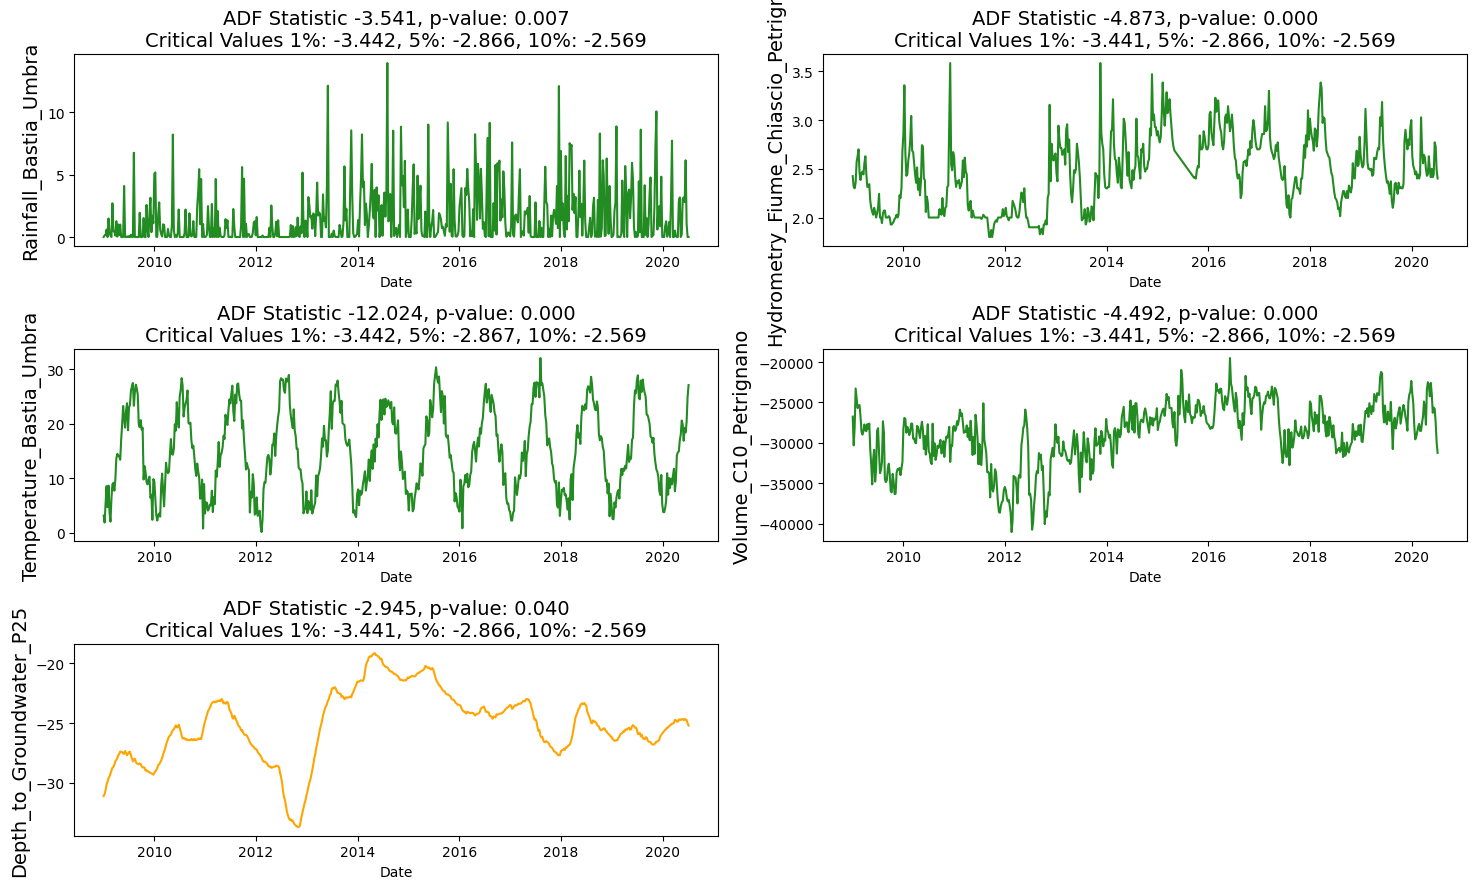

In [ ]:

fig, axis = plt.subplots(3, 2, figsize=(15, 9))

def ADFGraph(dataset, col, axis):
    result = adfuller(dataset[col])
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=dataset["Date"], y=dataset[col], ax=axis, color=linecolor)
    
    axis.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    axis.set_ylabel(ylabel=dataset[col].name, fontsize=14)

ADFGraph(weeklyData, "Rainfall_Bastia_Umbra", axis[0, 0])
ADFGraph(weeklyData, "Temperature_Bastia_Umbra", axis[1, 0])
ADFGraph(weeklyData, "Hydrometry_Fiume_Chiascio_Petrignano", axis[0, 1])
ADFGraph(weeklyData, "Volume_C10_Petrignano", axis[1, 1])
ADFGraph(weeklyData, "Depth_to_Groundwater_P25", axis[2, 0])

fig.delaxes(axis[2, 1])

plt.tight_layout()
plt.show()

- En la graficacion del Test de Dickey Fuller Aumentado podemos ver que los valores son estacionarios.

- Si bien el analisis nos dice que el nivel del agua de los acuiferos es estacionaria el grafico nos dice algo diferente. No hay patrón en la grafica.

- Para asegurar la estacionalidad necesiaria para utilizar un modelo ARIMA vamos a transformar los datos.

p-value: 0.0583.
No exporting data


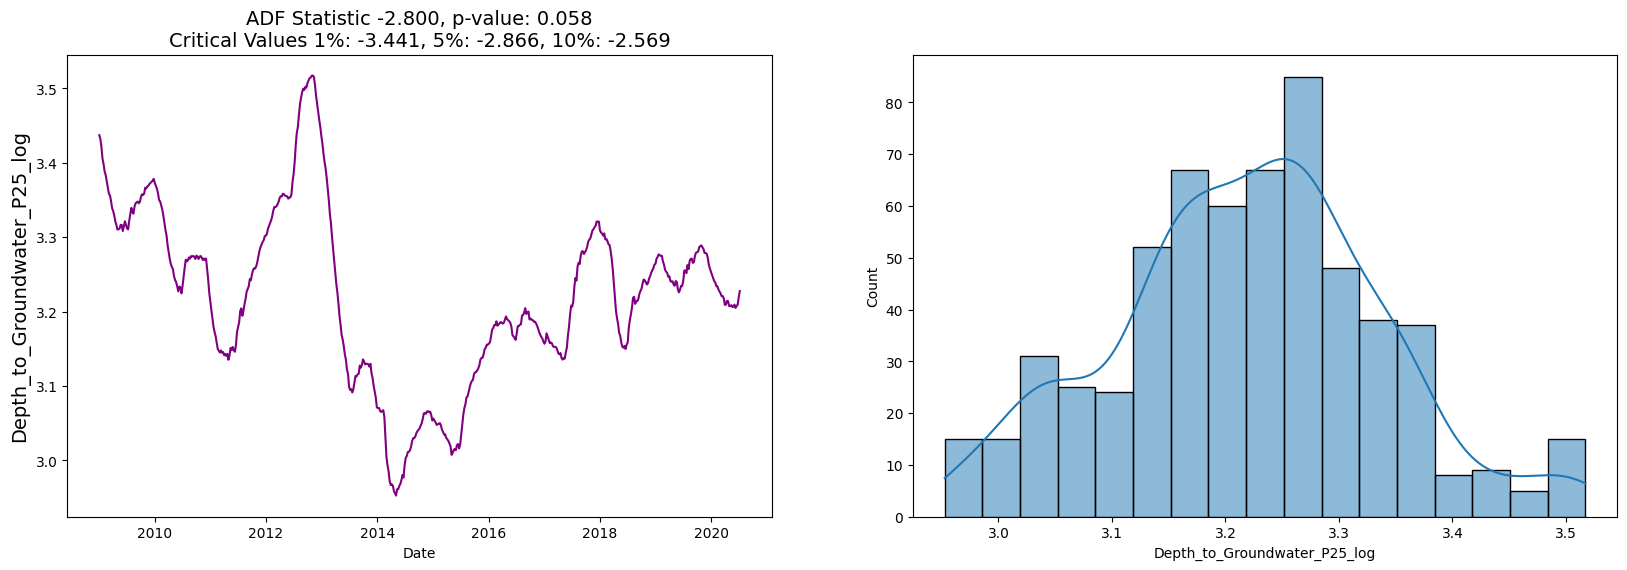

In [49]:
def Transforming(dataset):
    
    dataset["Depth_to_Groundwater_P25_log"] = np.log(abs(dataset["Depth_to_Groundwater_P25"]))

    fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    ADFGraph(dataset, "Depth_to_Groundwater_P25_log", axis[0])

    sns.histplot(dataset["Depth_to_Groundwater_P25_log"], ax=axis[1], kde = True)

    adf = adfuller(dataset["Depth_to_Groundwater_P25_log"])

    p_value = adf[1]

    if p_value > 0.05:
        print(f"p-value: {p_value:.4f}.\nNo exporting data")
        return None
    
    else:
        print(f"p_value: {p_value:.4f}\nExporting data...")
        return dataset

Transforming(weeklyData)

- Con la transformación logaritmica la serie pasa a ser no estacionaria, vamos a probar con la diferenciacion

p_value: 0.0000
Exporting data...


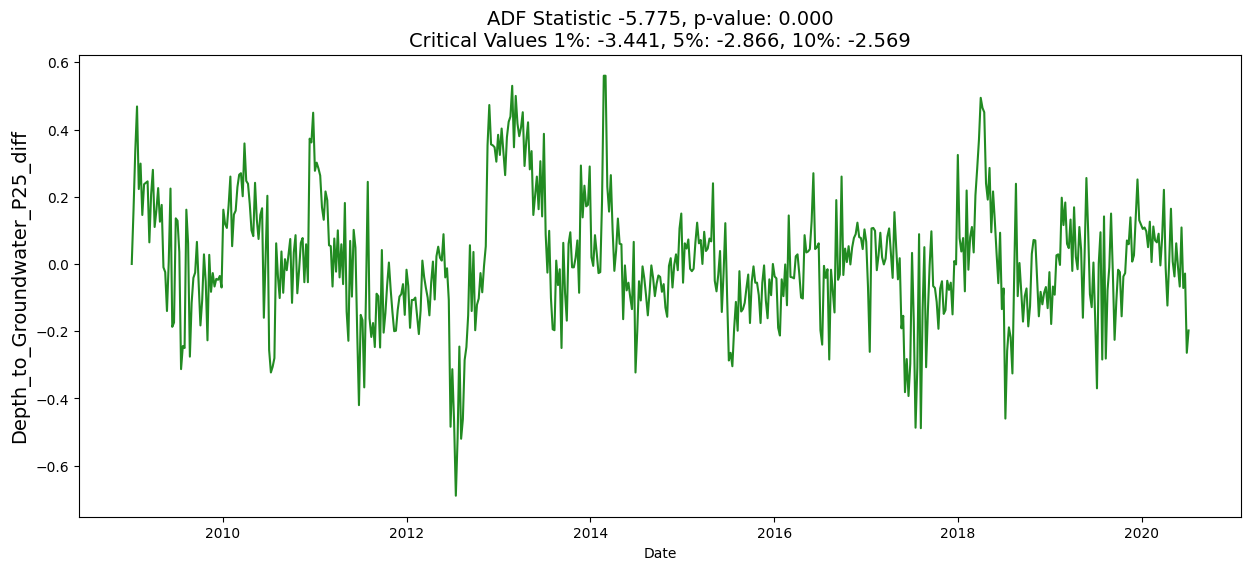

In [50]:
def FirstOrderDiff(dataset):
    
    diffData = np.diff(dataset["Depth_to_Groundwater_P25"])
    dataset["Depth_to_Groundwater_P25_diff"] = np.append([0], diffData)

    fig, axis = plt.subplots(1, 1, figsize=(15, 6))
    ADFGraph(dataset, "Depth_to_Groundwater_P25_diff", axis)
    
    adf = adfuller(dataset["Depth_to_Groundwater_P25_diff"])

    p_value = adf[1]

    if p_value > 0.05:
        return f"p-value: {p_value}.\nNot exporting data"
    
    else:
        print(f"p_value: {p_value:.4f}\nExporting data...")
        return dataset

stationary_data = FirstOrderDiff(weeklyData)

# Ingenieria de Caracteristicas

In [72]:
def FeatureEngineer(dataset):

    #Primero vamos a desglosar Date.
    dataset["year"] = pd.DatetimeIndex(dataset["Date"]).year
    dataset["month"] = pd.DatetimeIndex(dataset["Date"]).month
    dataset["day"] = pd.DatetimeIndex(dataset["Date"]).day
    dataset["dayofyear"] = pd.DatetimeIndex(dataset["Date"]).dayofyear
    dataset["weekofyear"] = (dataset["dayofyear"] - 1) // 7
    dataset["quarter"] = pd.DatetimeIndex(dataset["Date"]).quarter
    dataset["season"] = dataset["month"] %12 // 3

    #Ahora tenemos que codificar las caracteristicas cíclicas.

    months = 12
    dataset["monthSinus"] = np.sin(2*np.pi*dataset["month"]/months)
    dataset["monthCosinus"] = np.cos(2*np.pi*dataset["month"]/months)


    return dataset

final_data = FeatureEngineer(stationary_data)

In [73]:
final_data

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano,Depth_to_Groundwater_P25_log,Depth_to_Groundwater_P25_diff,year,month,day,dayofyear,weekofyear,quarter,season,monthSinus,monthCosinus
0,2009-01-04,0.000000,-31.092500,3.175000,-26750.520000,2.425000,3.436967,0.000000,2009,1,4,4,0,1,0,5.000000e-01,0.866025
1,2009-01-11,0.128571,-30.934286,1.914286,-30309.243429,2.314286,3.431865,0.158214,2009,1,11,11,1,1,0,5.000000e-01,0.866025
2,2009-01-18,0.171429,-30.598571,5.485714,-28089.257143,2.300000,3.420953,0.335714,2009,1,18,18,2,1,0,5.000000e-01,0.866025
3,2009-01-25,0.600000,-30.130000,8.585714,-23269.124571,2.357143,3.405521,0.468571,2009,1,25,25,3,1,0,5.000000e-01,0.866025
4,2009-02-01,0.000000,-29.907143,4.728571,-24487.117714,2.571429,3.398097,0.222857,2009,2,1,32,4,1,0,8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,2020-06-07,2.800000,-24.652857,19.271429,-25637.965714,2.442857,3.204893,0.108571,2020,6,7,159,22,2,2,1.224647e-16,-1.000000
597,2020-06-14,6.142857,-24.724286,18.428571,-25804.841143,2.771429,3.207786,-0.071429,2020,6,14,166,23,2,2,1.224647e-16,-1.000000
598,2020-06-21,1.057143,-24.752857,20.385714,-27476.496000,2.728571,3.208941,-0.028571,2020,6,21,173,24,2,2,1.224647e-16,-1.000000
599,2020-06-28,0.000000,-25.017143,24.928571,-29972.900571,2.485714,3.219561,-0.264286,2020,6,28,180,25,2,2,1.224647e-16,-1.000000


# Descomposicion de las Series Temporales

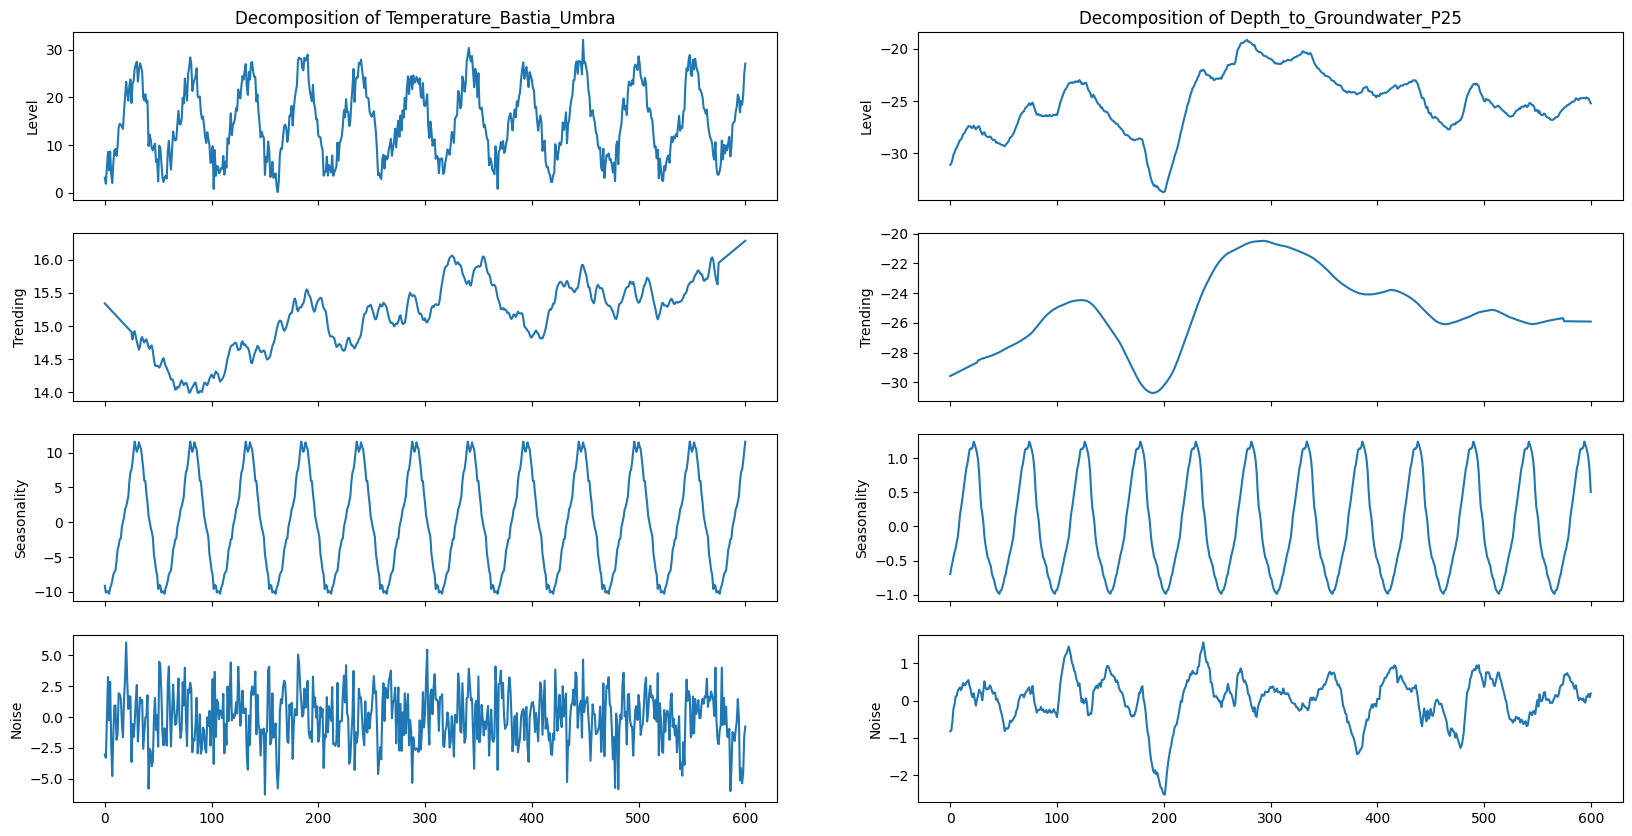

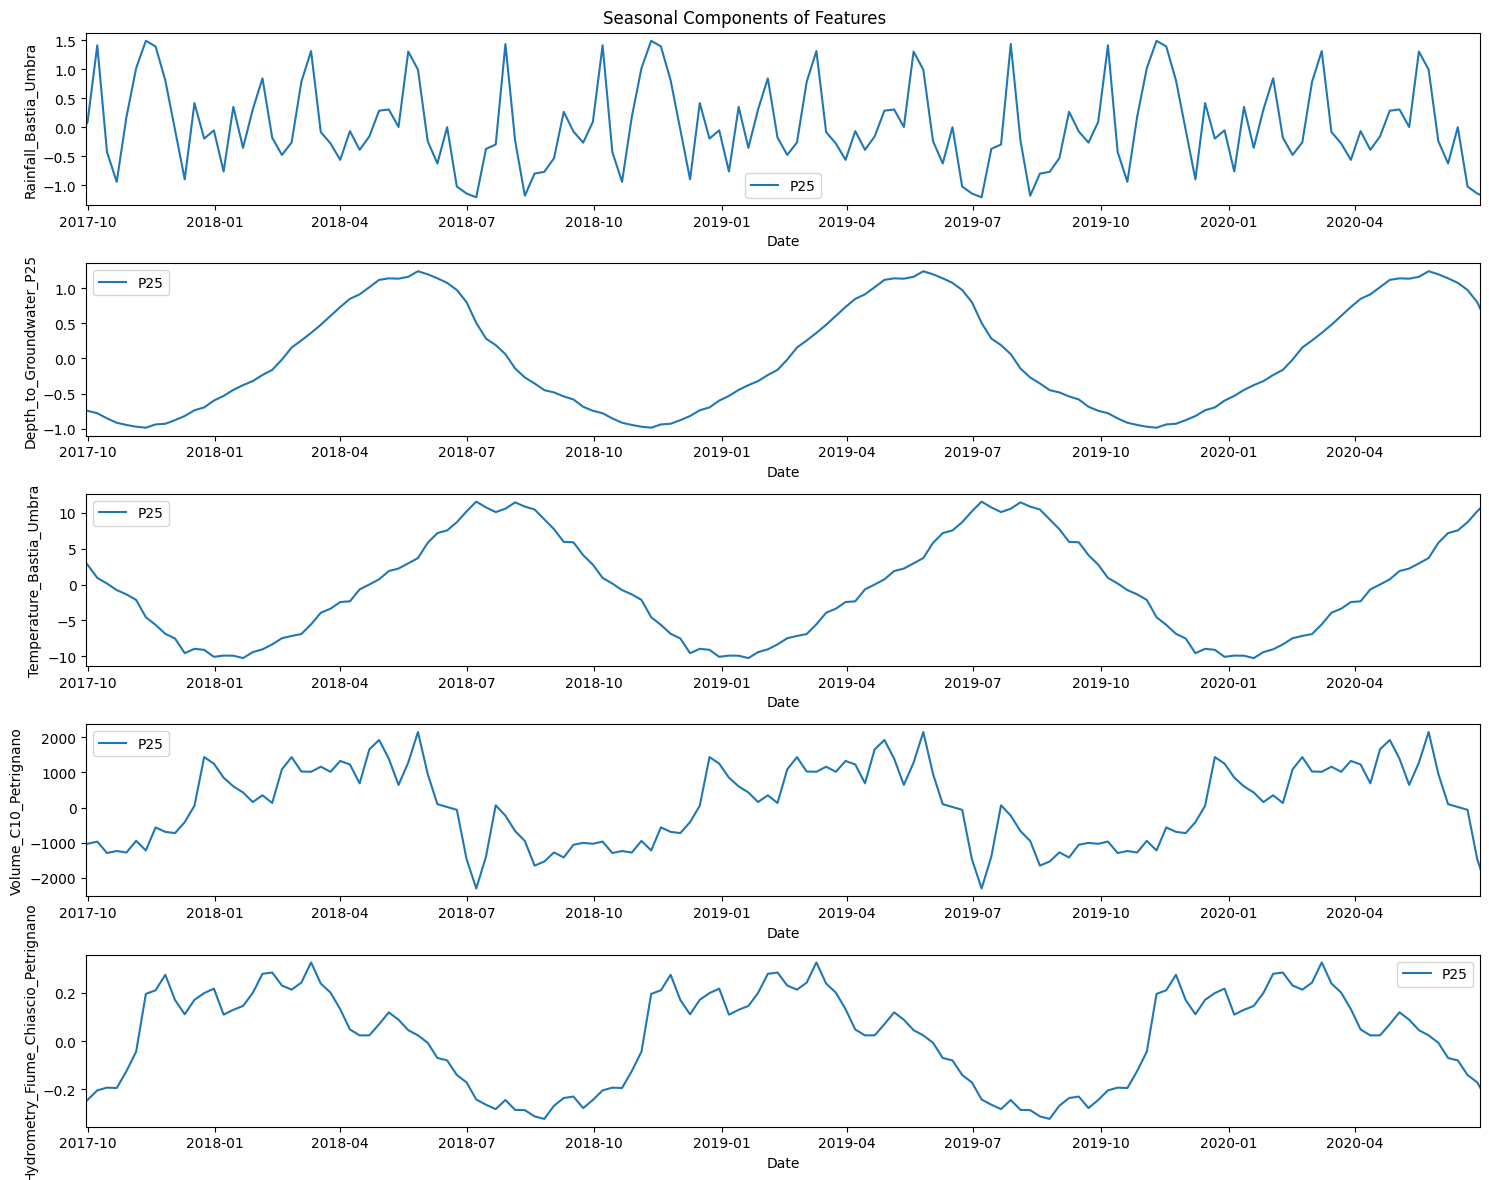

In [94]:
cols = ["Rainfall_Bastia_Umbra", "Depth_to_Groundwater_P25", "Temperature_Bastia_Umbra", "Volume_C10_Petrignano", "Hydrometry_Fiume_Chiascio_Petrignano"]

def SeasonalDecomposer(dataset, cols):
    
    for i in cols:
        decomps = seasonal_decompose(dataset[i], period=52, model='additive', extrapolate_trend='freq')
        dataset[f"{i}_trend"] = decomps.trend
        dataset[f"{i}_seasonal"] = decomps.seasonal

    #vamos a graficar el nivel, la tendencia, la estacionalidad y el ruido.

    fig, axis = plt.subplots(4, 2, sharex=True, figsize=(20,10))

    for i, col in enumerate(["Temperature_Bastia_Umbra", "Depth_to_Groundwater_P25"]):
        
        result = seasonal_decompose(dataset[col], period=52, model='additive', extrapolate_trend='freq')

        axis[0,i].set_title(f"Decomposition of {col}")
        result.observed.plot(ax=axis[0,i], legend=False)
        axis[0,i].set_ylabel("Level")

        result.trend.plot(ax=axis[1,i], legend=False)
        axis[1,i].set_ylabel("Trending")

        result.seasonal.plot(ax=axis[2,i], legend=False)
        axis[2,i].set_ylabel("Seasonality")
        
        result.resid.plot(ax=axis[3,i], legend=False)
        axis[3,i].set_ylabel("Noise")

    #Lag tengo yo en la cabeza ya.
    #Vamos a crear columnas en todas las features con lag para buscar patrones extras y poder ajustar el modelo.

    weeks = 4

    for col in cols:
        dataset[f'{col}_seasonal_shift_b_2m'] = dataset[f'{col}_seasonal'].shift(-2 * weeks)
        dataset[f'{col}_seasonal_shift_b_1m'] = dataset[f'{col}_seasonal'].shift(-1 * weeks)
        dataset[f'{col}_seasonal_shift_1m'] = dataset[f'{col}_seasonal'].shift(1 * weeks)
        dataset[f'{col}_seasonal_shift_2m'] = dataset[f'{col}_seasonal'].shift(2 * weeks)
        dataset[f'{col}_seasonal_shift_3m'] = dataset[f'{col}_seasonal'].shift(3 * weeks)

    #Vamos a analizar las series

    fig, axis = plt.subplots(5, 1, figsize=(15, 12))
    fig.suptitle('Seasonal Components of Features')

    for i, col in enumerate(cols):
        sns.lineplot(x=dataset['Date'], y=dataset[col + '_seasonal'], ax=axis[i], label='P25')
        axis[i].set_ylabel(ylabel=col)
        axis[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
        
    plt.tight_layout()
    plt.show()

    return dataset

data_decompos = SeasonalDecomposer(final_data, cols)

# Conclusiones

- Level: Es la observación original, nada más que añadir.
- Trending: La temperatura tiene una tendencia ascendente, la tendencia del nivel de los aquiferos es irregular y el pico de bajada coincide con los puntos de los que no teníamos datos reales por lo que a falta de más información tomare la tendencia como estable aunque sea algo ingenuo.
- Stationary: Nada que añadir, ambas son estacionales.
- Noise: El ruido de la temperatura no sigue ningún patrón por lo que está bien, en cuanto al ruido de los aquiferos se parece bastante a la figura original, esto puede deberse a que no hay una tendencia clara.

---------------

- Aquifero: Maximas en Junio, minimas en Noviembre
- Temperatura: Maximas en Junio - Agosto, minimas en Diciembre - Febrero
- Volumen: Maximas en Mayo, minimas en Julio.
- Hidrometría: Máximas en Marzo, mínimas en Septiembre.
- Lluvias: No hay una tendencia clara.

In [90]:
data_decompos

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano,Depth_to_Groundwater_P25_log,Depth_to_Groundwater_P25_diff,year,month,...,Volume_C10_Petrignano_seasonal_shift_b_2m,Volume_C10_Petrignano_seasonal_shift_b_1m,Volume_C10_Petrignano_seasonal_shift_1m,Volume_C10_Petrignano_seasonal_shift_2m,Volume_C10_Petrignano_seasonal_shift_3m,Hydrometry_Fiume_Chiascio_Petrignano_seasonal_shift_b_2m,Hydrometry_Fiume_Chiascio_Petrignano_seasonal_shift_b_1m,Hydrometry_Fiume_Chiascio_Petrignano_seasonal_shift_1m,Hydrometry_Fiume_Chiascio_Petrignano_seasonal_shift_2m,Hydrometry_Fiume_Chiascio_Petrignano_seasonal_shift_3m
0,2009-01-04,0.000000,-31.092500,3.175000,-26750.520000,2.425000,3.436967,0.000000,2009,1,...,1084.074387,428.008738,NaN,NaN,NaN,0.230386,0.145654,NaN,NaN,NaN
1,2009-01-11,0.128571,-30.934286,1.914286,-30309.243429,2.314286,3.431865,0.158214,2009,1,...,1430.687522,155.707450,NaN,NaN,NaN,0.213293,0.199750,NaN,NaN,NaN
2,2009-01-18,0.171429,-30.598571,5.485714,-28089.257143,2.300000,3.420953,0.335714,2009,1,...,1023.513024,348.475244,NaN,NaN,NaN,0.242434,0.278903,NaN,NaN,NaN
3,2009-01-25,0.600000,-30.130000,8.585714,-23269.124571,2.357143,3.405521,0.468571,2009,1,...,1015.311346,130.108730,NaN,NaN,NaN,0.326200,0.284326,NaN,NaN,NaN
4,2009-02-01,0.000000,-29.907143,4.728571,-24487.117714,2.571429,3.398097,0.222857,2009,2,...,1159.482140,1084.074387,1433.368027,NaN,NaN,0.238583,0.230386,0.199032,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,2020-06-07,2.800000,-24.652857,19.271429,-25637.965714,2.442857,3.204893,0.108571,2020,6,...,NaN,-2298.513968,642.168207,687.874195,1159.482140,NaN,-0.242283,0.088446,0.023567,0.238583
597,2020-06-14,6.142857,-24.724286,18.428571,-25804.841143,2.771429,3.207786,-0.071429,2020,6,...,NaN,NaN,1276.206924,1653.276000,1014.873692,NaN,NaN,0.045275,0.023940,0.200989
598,2020-06-21,1.057143,-24.752857,20.385714,-27476.496000,2.728571,3.208941,-0.028571,2020,6,...,NaN,NaN,2144.571124,1918.780838,1323.479431,NaN,NaN,0.023704,0.069936,0.132328
599,2020-06-28,0.000000,-25.017143,24.928571,-29972.900571,2.485714,3.219561,-0.264286,2020,6,...,NaN,NaN,955.954270,1387.956973,1223.367676,NaN,NaN,-0.007094,0.119266,0.048157


# Correlación de Caracteristicas.

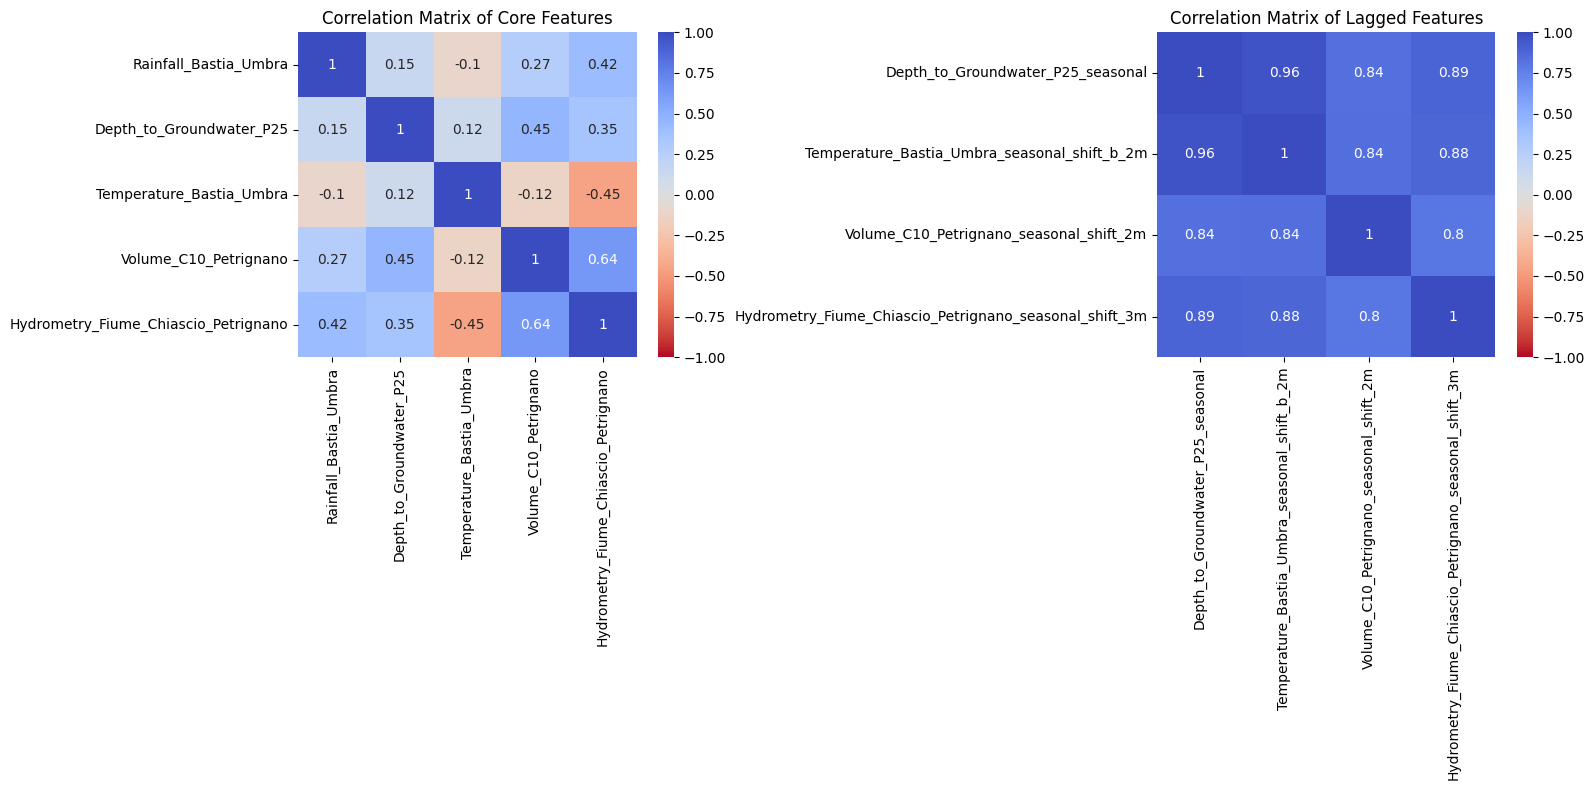

In [99]:
shift_cols = ['Depth_to_Groundwater_P25_seasonal', 'Temperature_Bastia_Umbra_seasonal_shift_b_2m', 'Volume_C10_Petrignano_seasonal_shift_2m', 'Hydrometry_Fiume_Chiascio_Petrignano_seasonal_shift_3m']

def FeatureCorrelation(dataset, cols, shift_cols):
    
    fig, axis = plt.subplots(1, 2, figsize=(16, 8))

    corrmat = dataset[cols].corr()

    sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=axis[0])
    axis[0].set_title('Correlation Matrix of Core Features')

    corrmat = dataset[shift_cols].corr()

    sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=axis[1])
    axis[1].set_title('Correlation Matrix of Lagged Features')


    plt.tight_layout()
    plt.show()

FeatureCorrelation(data_decompos, cols, shift_cols)

- Las estadisticas retrasadas están más correlacionadas que las originales, lo que significa que existe una fuerte relacion estacional entre ellas. 

# Auto-Correlacion

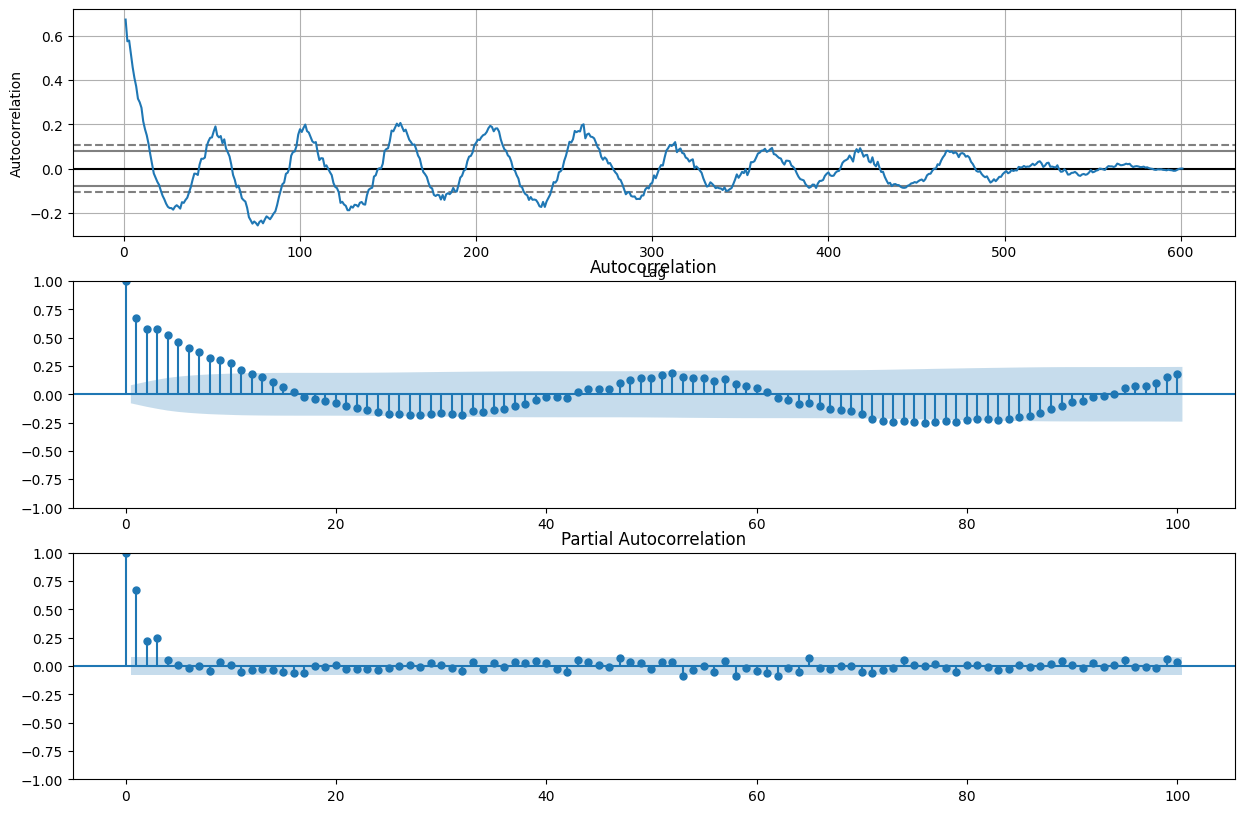

In [109]:
def Autocrrelation(dataset):
    
    fig, axis = plt.subplots(3, 1, figsize=(15, 10))

    autocorrelation_plot(dataset["Depth_to_Groundwater_P25_diff"], ax=axis[0])
    plot_acf(dataset["Depth_to_Groundwater_P25_diff"], lags=100, ax=axis[1])
    plot_pacf(dataset["Depth_to_Groundwater_P25_diff"], lags=100, ax=axis[2])

    plt.show()

Autocrrelation(data_decompos)

# MACHINE LEARNING

In [113]:
def SplitData(dataset):

    # Seleccionamos la variable target y cambiamos el nombre de las columnas para preparalo para prophet.
    univarData = dataset[["Date", "Depth_to_Groundwater_P25"]].rename(columns={"Date": 'ds', "Depth_to_Groundwater_P25": 'y'})

    # Spliteamos
    dataTrain, dataVal = train_test_split(univarData, test_size=0.2, shuffle=False)  # No mezclamos, es una serie TEMPORAL

    return dataTrain, dataVal

trainData, trainVal = SplitData(data_decompos)

In [134]:
model = Prophet()
model.fit(trainData)

yPred = model.predict(trainVal)

tailSize = int(len(yPred) * 0.20)

yPred_tail = yPred.iloc[-tailSize:]["yhat"]
trainVal_tail = trainVal.iloc[-tailSize:]["y"]

MAE = mean_absolute_error(trainVal_tail, yPred_tail)
RMSE = math.sqrt(mean_squared_error(trainVal_tail, yPred_tail))

print(f"MAE: {MAE}\nRMSE: {RMSE}")

06:02:41 - cmdstanpy - INFO - Chain [1] start processing
06:02:42 - cmdstanpy - INFO - Chain [1] done processing


MAE: 4.183543213020709
RMSE: 4.184823428467493


# Graficamos el modelo

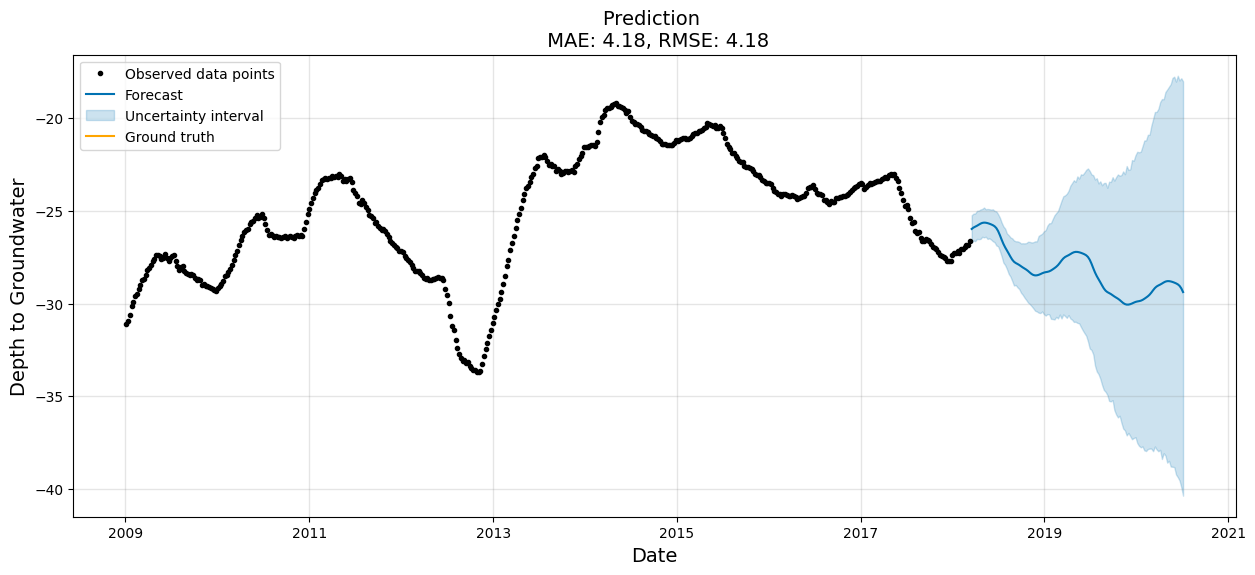

In [137]:
# Plot the forecast
fig, axis = plt.subplots(1)
fig.set_figheight(6)
fig.set_figwidth(15)

model.plot(yPred, ax=axis)
sns.lineplot(x=trainVal["ds"], y=yPred["yhat"], ax=axis, color='orange', label='Ground truth')

axis.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
axis.set_xlabel(xlabel='Date', fontsize=14)
axis.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()